# In-hospital mortality prediction using one-hot encoding
The task is to predict in-hospital mortality based on the first 48 hours of an ICU stay. The categorical variables of the first 48 hours are one-hot encoded in this notebook.

In [2]:
# Imports:
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from matplotlib import pyplot as plt
import seaborn as sn
import sys
sys.path.append('../')
#from plot_metrics import PlotMetrics
import tensorflow as tf
import imp
import warnings
warnings.filterwarnings('ignore')

### Extract task-specific data

In [4]:
# Extract the in-hospital mortality data:
X = pd.read_hdf('E:/MIMIC-III-ML/Preprocessing/notebooks/vitals_hourly_data_preprocessed.h5', 'X')
Y = pd.read_hdf('E:/MIMIC-III-ML/Preprocessing/notebooks/vitals_hourly_data_preprocessed.h5', 'Y')[['in_hospital_mortality', 'los']]

X = X.sort_index(axis = 0, level = 'icustay_id')
Y = Y.sort_index(axis = 0, level = 'icustay_id')

# Remove the icustays that were less than 48 hours:
indices_to_remove = []
for i, row in Y.iterrows():
    if row['los'] < 48:
        indices_to_remove.append(i)
        
X = X.reset_index().set_index('icustay_id').drop(indices_to_remove, axis = 0)
Y = Y.drop(indices_to_remove, axis = 0)

In [5]:
def create_x_matrix(x): # extract the first 48 hours for every icustay.
    zeros = np.zeros((48, x.shape[1]-4))
    x = x.values
    x = x[:48, 4:] # the first four columns are for subject_id, icustay_id, hadm_id and hours_in.
    zeros[0:x.shape[0], :] = x
    return zeros

def create_y_matrix(y):
    y = y['in_hospital_mortality'].to_numpy()
    return y

x = np.array(list(X.reset_index().groupby('icustay_id').apply(create_x_matrix)))
y = np.array(list(Y.groupby('icustay_id').apply(create_y_matrix)))[:, 0]

In [6]:
del X, Y

### Run logistic regression (baseline)

In [7]:
# Stratified 5-fold cross-validation:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
predictions_logreg = []
y_true_logreg = []
for train_index, test_index in kf.split(x, y):
    
    # Split in training and test set, and split the training further in training and validation sets 
    x_train, x_val, y_train, y_val = train_test_split(x[train_index], y[train_index], test_size=0.125, random_state=0, 
                                            stratify=y[train_index])
    x_test, y_test = x[test_index], y[test_index]
    
    # Reshape:
    x_train_lr = np.reshape(x_train, (x_train.shape[0], -1))
    x_val_lr = np.reshape(x_val, (x_val.shape[0], -1))
    x_test_lr = np.reshape(x_test, (x_test.shape[0], -1))
    
    # Initialize and fit a model:
    logreg = LogisticRegression(penalty = 'l2', C = 1, random_state = 0)
    logreg.fit(x_train_lr, y_train)
    
    # Make predictions:
    pred = logreg.predict_proba(x_test_lr)
    predictions_logreg.append(list(pred))
    y_true_logreg.append(list(y_test))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [9]:
x_train_lr.shape


(12298, 1728)

In [8]:
# Collect the results:
y_true_logreg_combined = np.concatenate(y_true_logreg)
predictions_logreg_combined = np.concatenate(predictions_logreg)

### LSTM model

<Figure size 432x288 with 0 Axes>

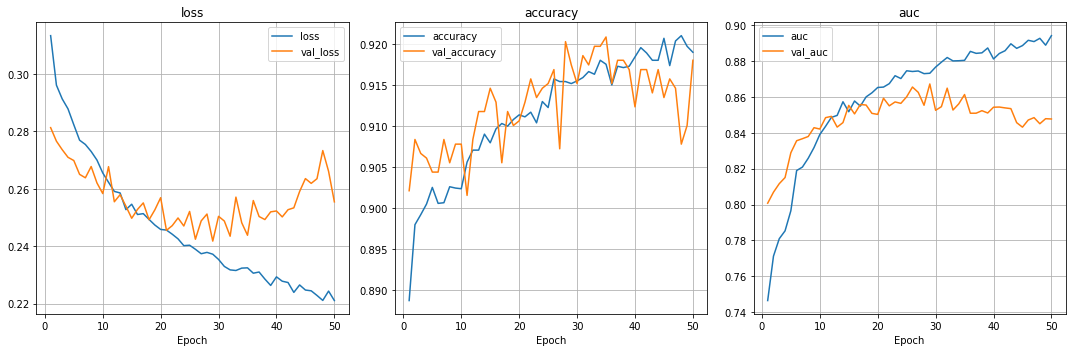


Epoch 00050: val_auc did not improve from 0.86723
440/440 [==============================] - 4s 4ms/step


<Figure size 432x288 with 0 Axes>

In [9]:
# Initialize the arrays for the results:
y_true_lstm, predictions_lstm = [], []
loss_train, loss_val = [], []
acc_train, acc_val, auc_train, auc_val = [], [], [], []

# Stratified 5-fold cross-validation:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)
for train_index, test_index in kf.split(x, y):
    
    # Split in training and test set, and split the training further in training and validation sets:
    x_train, x_val, y_train, y_val = train_test_split(x[train_index], y[train_index], test_size=0.125, random_state=0, 
                                            stratify=y[train_index])
    x_test, y_test = x[test_index], y[test_index]
    
    # Initialize the LSTM and parameters:
    model_module = imp.load_source(os.path.basename('../resources/lstm.py'), '../resources/lstm.py')
    lstm = model_module.Network(dim=16, batch_norm=False, dropout=0.3, depth=2, rec_dropout=0.0, task='ihm', batch_size=8)
    lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9), loss='binary_crossentropy', 
                 loss_weights=None, metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')])
    
    # Training:
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='lstm_one_hot_encoding', monitor='val_auc', 
                                                      verbose=1, mode='max', save_weights_only=True, save_best_only=True)
    history = lstm.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs=50, batch_size=8, 
                       callbacks=[PlotMetrics(), model_checkpoint])

    # Make predictions:
    lstm.load_weights('lstm_one_hot_encoding')
    pred = lstm.predict(x_test, batch_size=8, verbose=1)
    predictions_lstm.append(list(pred))
    y_true_lstm.append(list(y_test))
    
    # Save the loss and other metrics:
    loss_train.append(history.history['loss'])
    loss_val.append(history.history['val_loss'])
    acc_train.append(history.history['accuracy'])
    acc_val.append(history.history['val_accuracy'])
    auc_train.append(history.history['auc'])
    auc_val.append(history.history['val_auc'])

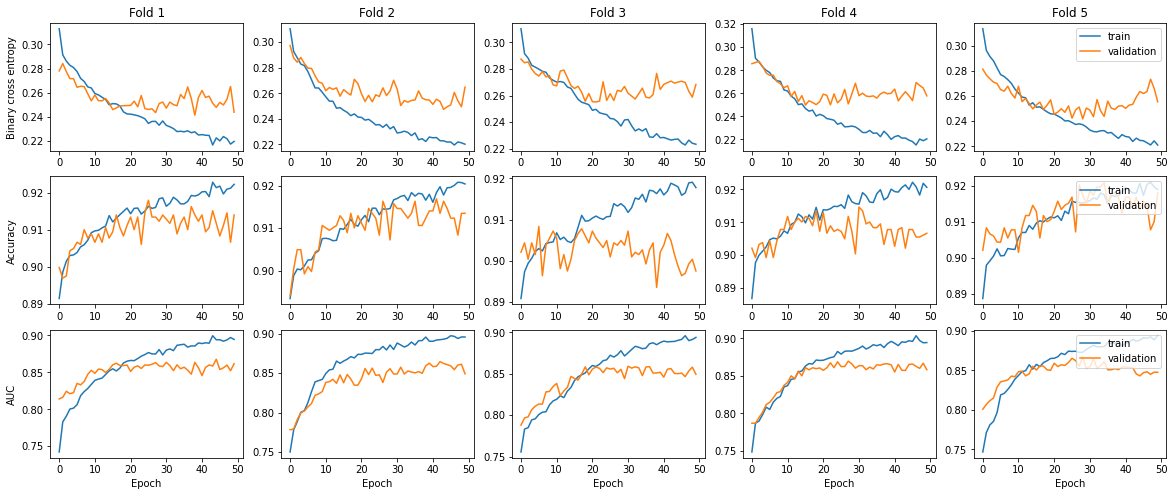

In [10]:
# Look at the loss for every fold:
fig, axs = plt.subplots(3, 5, figsize=(20, 8))
for i in range(5):
    axs[0, i].plot(np.arange(len(loss_train[i])), loss_train[i], label = 'train')
    axs[0, i].plot(np.arange(len(loss_val[i])), loss_val[i], label = 'validation')
    axs[0, i].set_title('Fold ' + str(i + 1))
    
    axs[1, i].plot(np.arange(len(acc_train[i])), acc_train[i], label = 'train')
    axs[1, i].plot(np.arange(len(acc_val[i])), acc_val[i], label = 'validation')
    
    axs[2, i].plot(np.arange(len(auc_train[i])), auc_train[i], label = 'train')
    axs[2, i].plot(np.arange(len(auc_val[i])), auc_val[i], label = 'validation')
    axs[2, i].set_xlabel('Epoch')
    
axs[0, 0].set_ylabel('Binary cross entropy')
axs[1, 0].set_ylabel('Accuracy')
axs[2, 0].set_ylabel('AUC')
axs[0, 4].legend(loc = 'upper right')
axs[1, 4].legend(loc = 'upper right')
axs[2, 4].legend(loc = 'upper right')

In [11]:
y_true_lstm_combined = np.concatenate(y_true_lstm)
predictions_lstm_combined = np.concatenate(predictions_lstm)

Text(609.9818181818181, 0.5, 'True label')

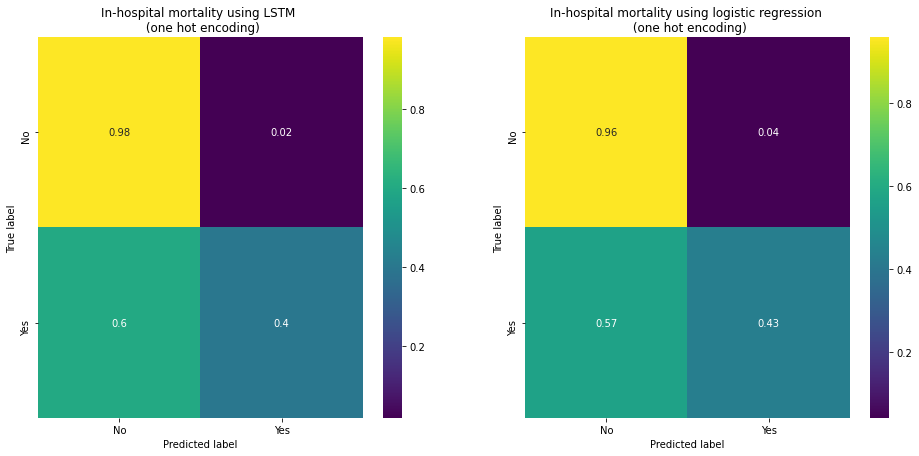

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# Confusion matrix for the baseline model:
cm = metrics.confusion_matrix(y_true_lstm_combined, np.round(predictions_lstm_combined), normalize = 'true')
df_cf = pd.DataFrame(np.round(cm, 2), index = ['No', 'Yes'], columns = ['No', 'Yes'])
sn.heatmap(df_cf, annot=True, cmap="viridis", ax = ax[0])
ax[0].set_title('In-hospital mortality using LSTM \n (one hot encoding)')
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')

# Confusion matrix for the baseline model:
cm = metrics.confusion_matrix(y_true_logreg_combined, np.argmax(predictions_logreg_combined, axis = 1), normalize = 'true')
df_cf = pd.DataFrame(np.round(cm, 2), index = ['No', 'Yes'], columns = ['No', 'Yes'])
sn.heatmap(df_cf, annot=True, cmap="viridis", ax = ax[1])
ax[1].set_title('In-hospital mortality using logistic regression \n (one hot encoding)')
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')

Text(0.5, 1.0, 'ROC curves for in-hospital mortality prediction \n (one hot encoding)')

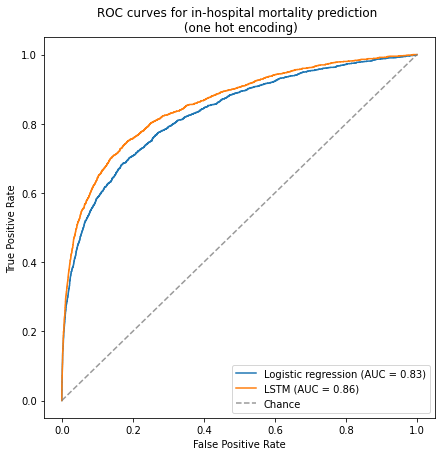

In [13]:
# ROC AUC curve:
roc_auc_logreg = metrics.roc_auc_score(y_true_logreg_combined, predictions_logreg_combined[:, 1])
fpr_logreg, tpr_logreg, threshold_logreg = metrics.roc_curve(y_true_logreg_combined, predictions_logreg_combined[:, 1])

roc_auc_lstm = metrics.roc_auc_score(y_true_lstm_combined, predictions_lstm_combined)
fpr_lstm, tpr_lstm, threshold_lstm = metrics.roc_curve(y_true_lstm_combined, predictions_lstm_combined)

fig, ax = plt.subplots(figsize = (7, 7))
ax.plot(fpr_logreg, tpr_logreg, label = 'Logistic regression (AUC = ' + str(round(roc_auc_logreg, 2)) + ')')
ax.plot(fpr_lstm, tpr_lstm, label = 'LSTM (AUC = ' + str(round(roc_auc_lstm, 2)) + ')')
ax.plot([0, 1], [0, 1], linestyle='--', color = 'gray', label = 'Chance', alpha=0.8)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for in-hospital mortality prediction \n (one hot encoding)')